# Build Basic Chatbot

In [2]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [23]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm = ChatGroq(model = "qwen/qwen3-32b")

In [9]:
## Node Functionality
def chatbot(state: State):
    return {"messages":[llm.invoke(state["messages"])]}

In [10]:
graph_builder = StateGraph(State)
graph_builder.add_node("llmchatbot", chatbot)

graph_builder.add_edge(START, "llmchatbot")
graph_builder.add_edge("llmchatbot", END)

##compile
graph = graph_builder.compile()

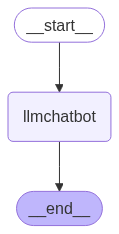

In [13]:
## Visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [15]:
response = graph.invoke({"messages": "Hi"})

In [17]:
response["messages"][-1].content

'<think>\nOkay, the user said "Hi". I need to respond appropriately. Since it\'s a greeting, I should start with a friendly greeting of my own. Let me make sure to use an emoji to keep it warm and approachable. I should also offer assistance, so the user knows I\'m here to help if they need anything. Let me check for any typos and keep the tone positive. Alright, that should cover it.\n</think>\n\nHi! 😊 How can I assist you today? Let me know if you have any questions or need help with anything!'

In [19]:
for event in graph.stream({"messages": "Hi How are you?"}):
    # print(event)
    for value in event.values():
        print(value)

{'messages': [AIMessage(content="<think>\nOkay, the user is asking how I am. I need to respond in a friendly and open way. Since I'm an AI, I don't have emotions, but I can mention that I'm here and ready to help. Keep it casual and invite them to ask anything. Make sure the tone is warm and approachable.\n</think>\n\nI'm just a pile of code, but I'm here and ready to help! 😊 How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 97, 'prompt_tokens': 13, 'total_tokens': 110, 'completion_time': 0.296292351, 'prompt_time': 0.105053245, 'queue_time': 0.045096035, 'total_time': 0.401345596}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--04e3ab12-8d9e-4282-a16e-62c44fb341ca-0', usage_metadata={'input_tokens': 13, 'output_tokens': 97, 'total_tokens': 110})]}


# Chatbot With Tool

In [24]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tool.invoke("What is langgraph")

{'query': 'What is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interaction

In [31]:
def multiply(a: int, b: int) -> int:
    '''Multiplies two integers and returns the result.'''
    return a * b

In [33]:
tools = [tool, multiply]

In [34]:
llm_with_tools = llm.bind_tools(tools)

In [ ]:
#StateGraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
 

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
# builder.add_edge("tools", END)
builder.add_edge("tools", "tool_calling_llm")


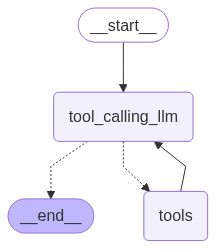

In [48]:
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [50]:
graph.invoke({"messages": "What is the recent ai news"})

{'messages': [HumanMessage(content='What is the recent ai news', additional_kwargs={}, response_metadata={}, id='7df0e005-dff2-45c6-b68d-1023f5360b46'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. Let me see how to approach this.\n\nFirst, I need to use the tavily_search function since it\'s about searching for information. The query is "recent ai news," so the main parameter here is the query itself. \n\nThe user mentioned "recent," which implies they want the latest information. In the tavily_search function, there\'s a parameter called time_range that can limit results to a specific timeframe. The options are day, week, month, year. Since "recent" could be interpreted as the last week or month, but AI news can be frequent, maybe setting time_range to "week" would be appropriate to get the latest updates without being too narrow. Alternatively, "month" might capture more coverage. Wait, the user might want the very lat

In [56]:
response = graph.invoke({"messages": "What is the recent ai news and what is 5*2"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news and what is 5*2
================================== Ai Message ==================================
Tool Calls:
  tavily_search (a9f355ztq)
 Call ID: a9f355ztq
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: week
    topic: general
  multiply (aj1tjq7qh)
 Call ID: aj1tjq7qh
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.cbsnews.com/news/ai-jobs-layoffs-us-2025/", "title": "AI is leading to thousands of job losses, report finds - CBS News", "content": "The impact of AI on hiring is perhaps most visible among younger workers. Job listings for the kind of entry-level corporate roles traditionally available to recent college graduates have declined 15% over th

# Adding Memory in Agentic Graph

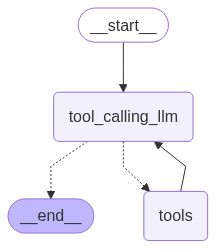

In [59]:
#StateGraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
 

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
# builder.add_edge("tools", END)
builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


In [60]:
config = {"configurable": {"thread_id": "1"}}

response = graph.invoke({"messages": "Hi my name is Tejaswini"}, config=config)
response

{'messages': [HumanMessage(content='Hi my name is Tejaswini', additional_kwargs={}, response_metadata={}, id='b5813717-fedf-4b36-951b-3e40de140271'),
  AIMessage(content='Hello Tejaswini! 😊 How can I assist you today?', additional_kwargs={'reasoning_content': 'Okay, the user said, "Hi my name is Tejaswini." Let me think about how to respond.\n\nFirst, I need to acknowledge their greeting. A simple "Hello" seems appropriate. Then, I should mention their name to make it personal. Maybe add an emoji to keep it friendly. Also, I should offer assistance since they might have a question or need help. Let me check if there\'s any other info needed, but the tools provided don\'t seem necessary here because it\'s just a greeting. So, no function calls are needed. Just a polite response.\n'}, response_metadata={'token_usage': {'completion_tokens': 138, 'prompt_tokens': 1814, 'total_tokens': 1952, 'completion_time': 0.410233522, 'prompt_time': 0.386472031, 'queue_time': 0.058050469, 'total_time':

In [61]:
response = graph.invoke({"messages": "Hey what is my name?"}, config=config)
response

{'messages': [HumanMessage(content='Hi my name is Tejaswini', additional_kwargs={}, response_metadata={}, id='b5813717-fedf-4b36-951b-3e40de140271'),
  AIMessage(content='Hello Tejaswini! 😊 How can I assist you today?', additional_kwargs={'reasoning_content': 'Okay, the user said, "Hi my name is Tejaswini." Let me think about how to respond.\n\nFirst, I need to acknowledge their greeting. A simple "Hello" seems appropriate. Then, I should mention their name to make it personal. Maybe add an emoji to keep it friendly. Also, I should offer assistance since they might have a question or need help. Let me check if there\'s any other info needed, but the tools provided don\'t seem necessary here because it\'s just a greeting. So, no function calls are needed. Just a polite response.\n'}, response_metadata={'token_usage': {'completion_tokens': 138, 'prompt_tokens': 1814, 'total_tokens': 1952, 'completion_time': 0.410233522, 'prompt_time': 0.386472031, 'queue_time': 0.058050469, 'total_time':

# Streaming

In [62]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [63]:
def superbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

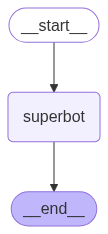

In [66]:
graph = StateGraph(State).add_node("superbot", superbot).add_edge(START, "superbot").add_edge("superbot", END).compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [68]:
config = {"configurable": {"thread_id": "1"}}

graph.invoke({"messages": "Hi my name is Tejaswini and i like cricket"}, config=config)

{'messages': [HumanMessage(content='Hi my name is Tejaswini and i like cricket', additional_kwargs={}, response_metadata={}, id='f21d18f9-b1bd-464e-b44e-eba54ef497c9'),
  AIMessage(content="Hi Tejaswini! It's great to meet you. Cricket is an amazing sport—do you follow any particular teams or players? 😊", additional_kwargs={'reasoning_content': "Okay, the user introduced herself as Tejaswini and mentioned she likes cricket. I need to respond appropriately. Let me check if there are any functions I should use here. The available functions are tavily_search and multiply. Since she's talking about her interests, there's no need for a search or multiplication. I should just acknowledge her message and maybe ask a follow-up question. Let me make sure I'm not missing any hidden queries. She didn't ask for anything specific, so a friendly response is best.\n"}, response_metadata={'token_usage': {'completion_tokens': 140, 'prompt_tokens': 1818, 'total_tokens': 1958, 'completion_time': 0.342293

In [70]:
config = {"configurable": {"thread_id": "3"}}

for chunk in graph.stream({"messages": "Hi my name is Tejaswini and i like cricket"}, config=config, stream_mode = "updates"):
    print(chunk)

{'superbot': {'messages': [AIMessage(content='Hello Tejaswini! Nice to meet you. 🏏 Since you mentioned you like cricket, do you follow any particular team or player closely? Or do you play the game yourself?', additional_kwargs={'reasoning_content': "Okay, the user introduced themselves as Tejaswini and mentioned they like cricket. I need to respond appropriately. Let me think.\n\nFirst, I should acknowledge her introduction. Maybe say hello and express that it's nice to meet her. Then, since she mentioned liking cricket, I can ask her some questions to engage in a conversation. Like, how long has she been following cricket? Or does she play any specific position? Also, maybe ask about her favorite team or player. That could help in understanding her interests better and keep the conversation going. I should keep the tone friendly and open-ended to encourage her to share more. Let me make sure the questions are not too personal but still engaging. Yeah, something like that should work.

In [71]:
config = {"configurable": {"thread_id": "3"}}

for chunk in graph.stream({"messages": "Hi my name is Tejaswini and i like cricket"}, config=config, stream_mode = "values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi my name is Tejaswini and i like cricket', additional_kwargs={}, response_metadata={}, id='93d9cd56-a4c0-4397-a2e7-136cefdb9cd8'), AIMessage(content='Hello Tejaswini! Nice to meet you. 🏏 Since you mentioned you like cricket, do you follow any particular team or player closely? Or do you play the game yourself?', additional_kwargs={'reasoning_content': "Okay, the user introduced themselves as Tejaswini and mentioned they like cricket. I need to respond appropriately. Let me think.\n\nFirst, I should acknowledge her introduction. Maybe say hello and express that it's nice to meet her. Then, since she mentioned liking cricket, I can ask her some questions to engage in a conversation. Like, how long has she been following cricket? Or does she play any specific position? Also, maybe ask about her favorite team or player. That could help in understanding her interests better and keep the conversation going. I should keep the tone friendly and open-ended 

In [73]:
config = {"configurable": {"thread_id": "4"}}

for chunk in graph.stream({"messages": "Hi my name is Tejaswini and i like cricket"}, config=config, stream_mode = "updates"):
    print(chunk)

{'superbot': {'messages': [AIMessage(content='Hello again, Tejaswini! 😊 How can I assist you today? If you have any questions about cricket or anything else, feel free to ask!', additional_kwargs={'reasoning_content': "Okay, the user introduced herself as Tejaswini and mentioned she likes cricket. The previous response was a greeting and asked about her interest in cricket. Now, the user is repeating the same message. Maybe she didn't get a response she expected or is testing the system.\n\nI need to check if there's a need for further action. Since she likes cricket, maybe suggest some cricket-related topics. But the tools available are Tavily Search and Multiply. Since she hasn't asked a question that requires a tool, there's no need to call any functions. Just respond politely again and offer assistance.\n"}, response_metadata={'token_usage': {'completion_tokens': 160, 'prompt_tokens': 1903, 'total_tokens': 2063, 'completion_time': 0.436694872, 'prompt_time': 0.096942546, 'queue_tim

In [74]:
for chunk in graph.stream({"messages": "I also like football"}, config=config, stream_mode = "values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi my name is Tejaswini and i like cricket', additional_kwargs={}, response_metadata={}, id='f86859a4-d254-4bcb-bbe3-fc66ac9039a5'), AIMessage(content="Hello Tejaswini! It's great to meet you. 🏏 I know cricket is an exciting sport - do you play it, or are you a fan of watching matches? If you have any specific questions about cricket rules, teams, or players you'd like to discuss, feel free to ask!", additional_kwargs={'reasoning_content': "Okay, the user introduced herself as Tejaswini and mentioned she likes cricket. I need to respond appropriately. Since there's no specific question here, my goal is to engage in a friendly conversation. Let me ask her more about her interest in cricket. Maybe find out if she's a player, a fan of a particular team, or has a favorite player. That way, I can continue the conversation and maybe help her find information related to cricket if she needs it. No need to call any functions here since there's no actionable 

# Human in the loop

In [75]:
import os
from langchain.chat_models import init_chat_model

llm = init_chat_model("groq:qwen/qwen3-32b")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000202D5832570>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000202D663F4D0>, model_name='qwen/qwen3-32b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [76]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str):
    """ Request assistance from a human."""

    human_response = interrupt({"query": query})
    return human_response

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("llmchatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools))

graph_builder.add_conditional_edges(
    "llmchatbot", tools_condition
)

graph_builder.add_edge("tools", "llmchatbot")
graph_builder.add_edge(START, "llmchatbot")

graph = graph_builder.compile(checkpointer=MemorySaver())

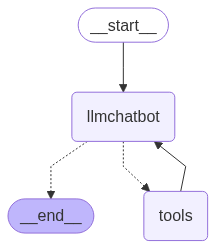

In [77]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [79]:
user_input = "I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream({"messages": user_input}, config=config, stream_mode="values")

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (0411be34m)
 Call ID: 0411be34m
  Args:
    query: I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?


In [80]:
human_response = (
    "We, the experts are here to help! We'd recommend you check the Langgraph to build your agent."
    "It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume= {"data": human_response})

events = graph.stream(human_command, config=config, stream_mode="values")

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (0411be34m)
 Call ID: 0411be34m
  Args:
    query: I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?
================================= Tool Message =================================
Name: human_assistance

{"data": "We, the experts are here to help! We'd recommend you check the Langgraph to build your agent.It's much more reliable and extensible than simple autonomous agents."}
================================== Ai Message ==================================

The experts recommend exploring **Langgraph** for building your AI agent. Langgraph is a framework designed for creating **reliable and extensible** agents, offering advantages over simpler autonomous agent implementations. It provides structured workflows, better modularity, and advanced capabilities for handling complex tasks.

Would you like guidance on how to get